In [1]:
import networkx as nx

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib as mpl

import random
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
# hyperparameters

seed = random.randint(1, 1000)         # random seed

# Experiments on real data
Here we use 'Garfield citations network' from 'Stacking models for nearly optimal link prediction in complex networks' paper by Amir Ghasemian et al:
 - https://github.com/Aghasemian/OptimalLinkPrediction
 - https://www.pnas.org/content/117/38/23393 

## Step 1
### Graph and features imoprting, train-test splitting

We import the desired network and its features from `OLP` class and split the data into train and test sets.

In [3]:
from lib.generators.OLP import OLP


generator = OLP(
    network_name='Malaria_var_DBLa_HVR_networks_HVR_networks_9', 
    seed=seed
)

feature_names = generator.feature_names

Loading file...
File loaded!
Calculating features...
Features calculated!
Train/test splitting...
Done splitting the data!


In [4]:
link_prediction_train, link_prediction_test, classifier_test = generator.TRAIN1_DF, generator.TEST1_DF, generator.TEST2_DF

In [5]:
link_prediction_train.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean
0,215,238,0,0.022727,0.0,0.001610,0.001426,0.108360,0.020408,0.235377,0.014286,-7.910339e-16,0.022727,0.037037
1,100,188,0,0.090909,0.0,0.002299,0.001942,0.304882,0.047619,1.032253,0.083312,-1.311451e-15,0.090909,0.133333
2,77,130,0,0.409091,0.0,0.006303,0.005220,0.500878,0.195652,4.412849,0.306612,7.979728e-16,0.409091,0.264706
3,48,112,0,0.045455,0.0,0.006667,0.000357,0.051985,0.031746,0.476551,0.030090,-2.532696e-16,0.045455,0.400000
4,77,107,0,0.363636,0.0,0.005602,0.005248,0.500878,0.170213,4.013556,0.302929,3.122502e-16,0.363636,0.235294


## Step 2
### Link prediction model

In [6]:
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model.fit(link_prediction_train[feature_names], link_prediction_train['goal'])

prob = model.predict_proba(link_prediction_test[feature_names])[:, 1]
prob = pd.Series(prob, name='prob')

link_proba = link_prediction_train.join(prob)
link_proba.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob
0,215,238,0,0.022727,0.0,0.001610,0.001426,0.108360,0.020408,0.235377,0.014286,-7.910339e-16,0.022727,0.037037,0.035108
1,100,188,0,0.090909,0.0,0.002299,0.001942,0.304882,0.047619,1.032253,0.083312,-1.311451e-15,0.090909,0.133333,0.244984
2,77,130,0,0.409091,0.0,0.006303,0.005220,0.500878,0.195652,4.412849,0.306612,7.979728e-16,0.409091,0.264706,0.677159
3,48,112,0,0.045455,0.0,0.006667,0.000357,0.051985,0.031746,0.476551,0.030090,-2.532696e-16,0.045455,0.400000,0.035108
4,77,107,0,0.363636,0.0,0.005602,0.005248,0.500878,0.170213,4.013556,0.302929,3.122502e-16,0.363636,0.235294,0.035108


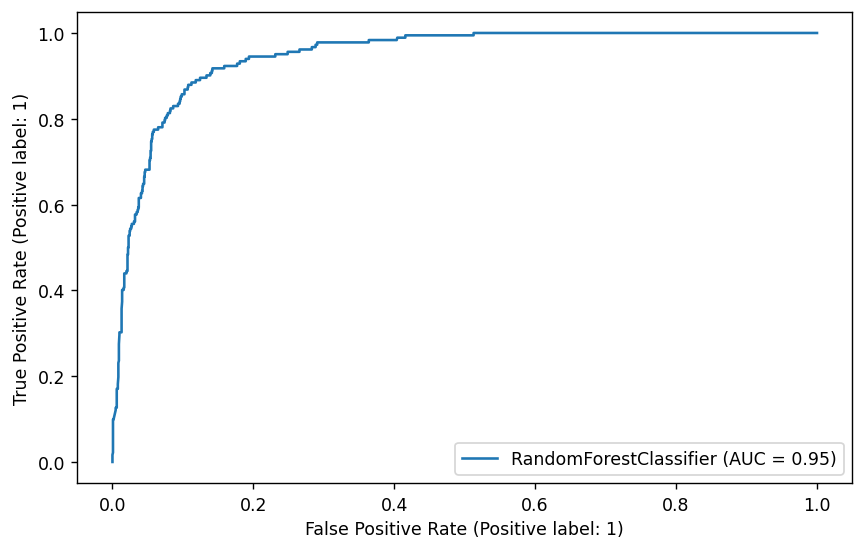

In [7]:
# ROC-AUC for the link prediction model
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model, link_prediction_test[feature_names], link_prediction_test['goal'])  

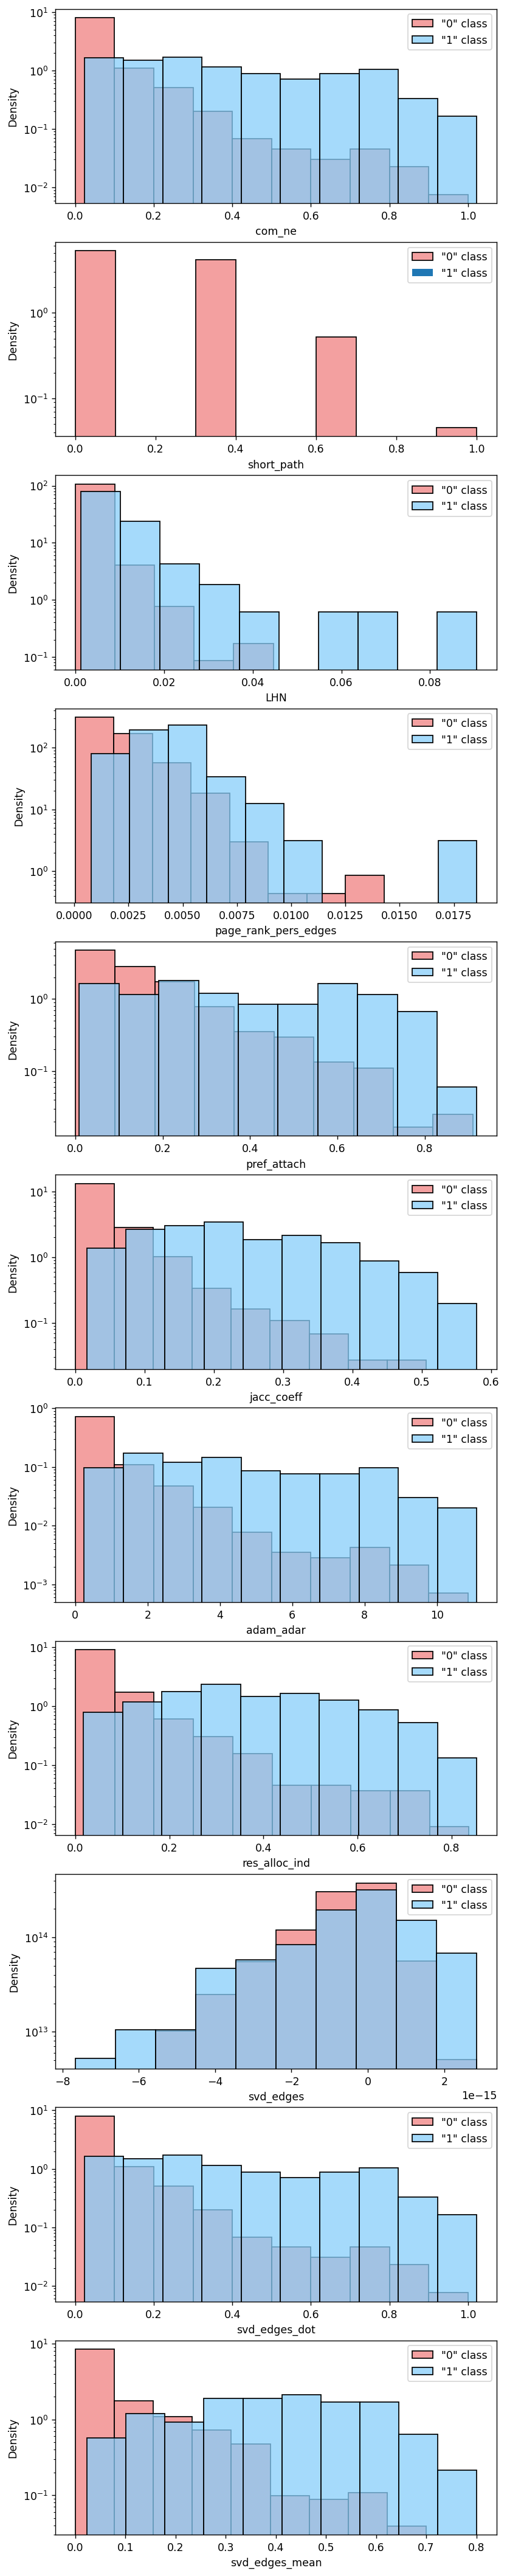

In [8]:
# distribution of features of exesting and non-existing edges

mpl.rcParams['figure.figsize'] = [7.5, 4*len(feature_names)]

fig, axs = plt.subplots(ncols=1, nrows=len(feature_names))
colors = ['lightcoral', 'lightskyblue']

for i, feature in enumerate(feature_names):
    width = (link_prediction_test[feature].max()-link_prediction_test[feature].min())/10
    for j in [0, 1]:
        data = link_prediction_test[link_prediction_test['goal'] == j]

        sn.histplot(data, x=feature, ax=axs[i], binwidth=width, color=colors[j], stat='density', label=f'"{j}" class')
        axs[i].set(xlabel=feature, ylabel='Density')
        axs[i].set_yscale("log")
        axs[i].legend()


## Step 3
Classifing error of prediction into "predictible" and "non-predictable" classes using median error

In [9]:
# absolute eroor of prediction
link_proba['abs_error'] = link_proba.apply(lambda row: math.fabs(row['goal']-row['prob']), axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error
0,215,238,0,0.022727,0.0,0.001610,0.001426,0.108360,0.020408,0.235377,0.014286,-7.910339e-16,0.022727,0.037037,0.035108,0.035108
1,100,188,0,0.090909,0.0,0.002299,0.001942,0.304882,0.047619,1.032253,0.083312,-1.311451e-15,0.090909,0.133333,0.244984,0.244984
2,77,130,0,0.409091,0.0,0.006303,0.005220,0.500878,0.195652,4.412849,0.306612,7.979728e-16,0.409091,0.264706,0.677159,0.677159
3,48,112,0,0.045455,0.0,0.006667,0.000357,0.051985,0.031746,0.476551,0.030090,-2.532696e-16,0.045455,0.400000,0.035108,0.035108
4,77,107,0,0.363636,0.0,0.005602,0.005248,0.500878,0.170213,4.013556,0.302929,3.122502e-16,0.363636,0.235294,0.035108,0.035108


In [10]:
train_median_error = link_proba['abs_error'].median()
train_median_error

0.4220376561182896

In [11]:
link_proba['quality_label'] = link_proba.apply(lambda row: 1 if row['abs_error'] <= train_median_error else 0, axis=1)
link_proba.head()

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prob,abs_error,quality_label
0,215,238,0,0.022727,0.0,0.001610,0.001426,0.108360,0.020408,0.235377,0.014286,-7.910339e-16,0.022727,0.037037,0.035108,0.035108,1
1,100,188,0,0.090909,0.0,0.002299,0.001942,0.304882,0.047619,1.032253,0.083312,-1.311451e-15,0.090909,0.133333,0.244984,0.244984,1
2,77,130,0,0.409091,0.0,0.006303,0.005220,0.500878,0.195652,4.412849,0.306612,7.979728e-16,0.409091,0.264706,0.677159,0.677159,0
3,48,112,0,0.045455,0.0,0.006667,0.000357,0.051985,0.031746,0.476551,0.030090,-2.532696e-16,0.045455,0.400000,0.035108,0.035108,1
4,77,107,0,0.363636,0.0,0.005602,0.005248,0.500878,0.170213,4.013556,0.302929,3.122502e-16,0.363636,0.235294,0.035108,0.035108,1


In [12]:
model_2 = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=seed)
model_2.fit(link_proba[feature_names], link_proba['quality_label'])

RandomForestClassifier(max_depth=3, random_state=652)

In [13]:
# testing the classifier

pred = model_2.predict(classifier_test[feature_names])
pred = pd.Series(pred, name='predicted_quality_label')

proba = model.predict_proba(classifier_test[feature_names])[:,1]
proba = pd.Series(proba, name='prediction_probability')

classifier_test = classifier_test.join(proba)
classifier_test = classifier_test.join(pred)

In [14]:
classifier_test['true_abs_error'] = classifier_test.apply(lambda row: math.fabs(row['goal']-row['prediction_probability']), axis=1)
test_median_error = classifier_test['true_abs_error'].median()
test_median_error

0.05518438995294772

In [15]:
classifier_test['true_quality_label'] = classifier_test.apply(lambda row: 1 if row['true_abs_error'] <= test_median_error else 0, axis=1)
classifier_test.head(5)

,node1,node2,goal,com_ne,short_path,LHN,page_rank_pers_edges,pref_attach,jacc_coeff,adam_adar,res_alloc_ind,svd_edges,svd_edges_dot,svd_edges_mean,prediction_probability,predicted_quality_label,true_abs_error,true_quality_label
0,76,227,0,0.204545,0.000000,0.003830,0.003363,0.412013,0.102273,2.261196,0.170243,-1.464107e-15,2.045455e-01,1.800000e-01,0.557803,0,0.557803,0
1,52,191,0,0.181818,0.000000,0.003599,0.002634,0.389708,0.090909,1.974405,0.140114,-1.144917e-15,1.818182e-01,2.051282e-01,0.345127,0,0.345127,0
2,71,141,0,0.000000,0.333333,0.000000,0.002016,0.216895,0.000000,0.000000,0.000000,1.375636e-15,7.653381e-15,1.503099e-16,0.034035,1,0.034035,1
3,219,271,0,0.045455,0.000000,0.002778,0.001374,0.125746,0.033898,0.699404,0.117816,-9.714451e-17,4.545455e-02,1.250000e-01,0.152903,1,0.152903,0
4,45,208,0,0.022727,0.000000,0.001499,0.001079,0.116438,0.019608,0.237830,0.014925,-6.401130e-16,2.272727e-02,4.347826e-02,0.043890,1,0.043890,1


In [16]:
classifier_test[['true_quality_label']].value_counts()

true_quality_label
1                     748
0                     747
dtype: int64

In [17]:
classifier_test[['predicted_quality_label']].value_counts()

predicted_quality_label
1                          1108
0                           387
dtype: int64

In [18]:
from sklearn import metrics

y_true, y_pred = classifier_test['true_quality_label'], classifier_test['predicted_quality_label']

scores_df = pd.DataFrame()
scores_df['Metric'] = pd.Series(['Sample length', 'Accuracy', 'Precision', 'Recall', 'F1 score'])

scores_df['Score'] = pd.Series([
    len(classifier_test),
    model_2.score(classifier_test[feature_names], classifier_test['true_quality_label']),
    metrics.precision_score(y_true, y_pred, average='macro'),
    metrics.recall_score(y_true, y_pred, average='micro'),
    metrics.f1_score(y_true, y_pred, average='weighted')
])

scores_df

,Metric,Score
0,Sample length,1495.000000
1,Accuracy,0.723077
2,Precision,0.790477
3,Recall,0.723077
4,F1 score,0.705978


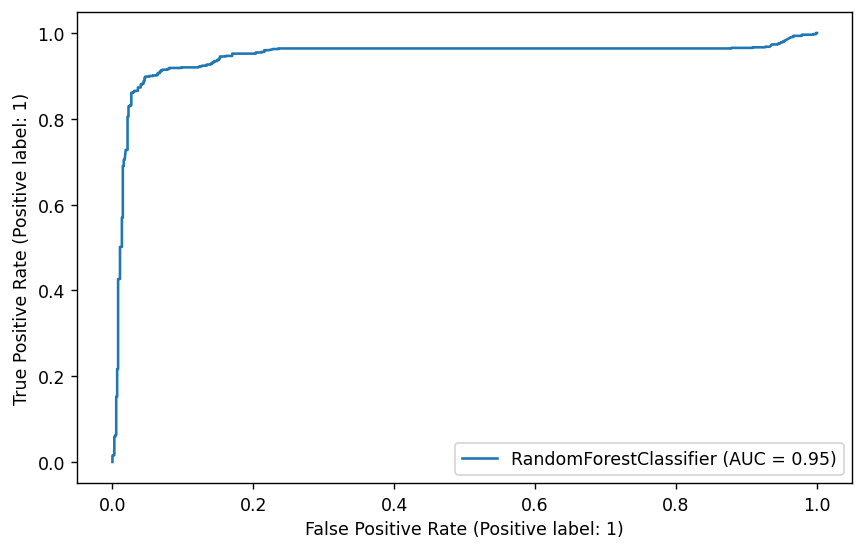

In [19]:
mpl.rcParams['figure.figsize'] = [8, 5]
mpl.rcParams['figure.dpi'] = 125

metrics.plot_roc_curve(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])  

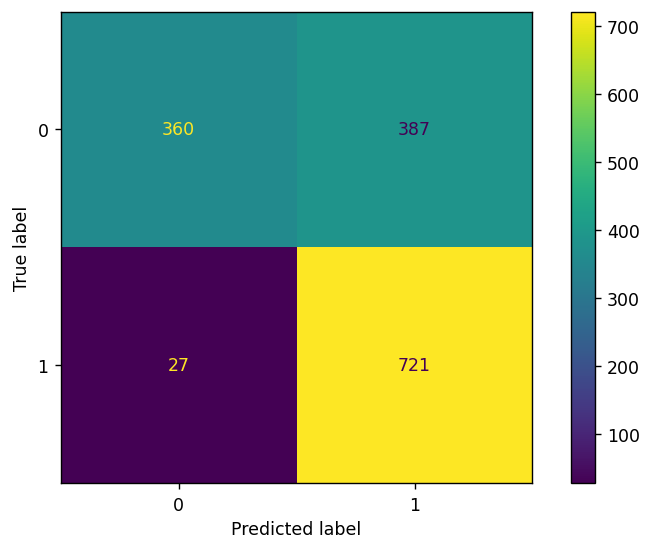

In [20]:
metrics.plot_confusion_matrix(model_2, classifier_test[feature_names], classifier_test['true_quality_label'])